In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno  as msno
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, f_classif

In [37]:
macapa = pd.read_csv('../data/macapa.txt')

In [38]:
macapa.columns

Index(['codigo_estacao', 'data', 'hora', 'temp_inst', 'temp_max', 'temp_min',
       'umid_inst', 'umid_max', 'umid_min', 'pto_orvalho_inst',
       'pto_orvalho_max', 'pto_orvalho_min', 'pressao', 'pressao_max',
       'pressao_min', 'vento_vel', 'vento_direcao', 'vento_rajada', 'radiacao',
       'precipitacao'],
      dtype='object')

In [39]:
macapa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8604 entries, 0 to 8603
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_estacao    8604 non-null   object 
 1   data              8604 non-null   object 
 2   hora              8604 non-null   int64  
 3   temp_inst         8604 non-null   float64
 4   temp_max          8604 non-null   float64
 5   temp_min          8604 non-null   float64
 6   umid_inst         8604 non-null   int64  
 7   umid_max          8604 non-null   int64  
 8   umid_min          8604 non-null   int64  
 9   pto_orvalho_inst  8604 non-null   float64
 10  pto_orvalho_max   8604 non-null   float64
 11  pto_orvalho_min   8604 non-null   float64
 12  pressao           8604 non-null   float64
 13  pressao_max       8604 non-null   float64
 14  pressao_min       8604 non-null   float64
 15  vento_vel         7726 non-null   float64
 16  vento_direcao     7731 non-null   float64


# Tratando dados Faltantes

In [40]:
macapa = macapa.drop(columns = ['vento_rajada'])

In [41]:
# tabela percentual de dados faltantes
def tabela_faltantes():
    features_numericas = ["hora","temp_inst", "temp_max", "temp_min", "umid_inst","umid_max","umid_min",
                          "pto_orvalho_inst", "pto_orvalho_max", "pto_orvalho_min","pressao","pressao_max",
                          "pressao_min","vento_vel", "vento_direcao","radiacao","precipitacao"]

    df = macapa[features_numericas]


    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)


    missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Dados Ausentes', '% Percentual'])
    missing_data.index.name =' Variaveis numericas'
    return missing_data

In [42]:
tabela_faltantes()

,Dados Ausentes,% Percentual
Variaveis numericas,,
vento_vel,878,0.102046
vento_direcao,873,0.101464
precipitacao,2,0.000232
umid_min,0,0.000000
temp_inst,0,0.000000
temp_max,0,0.000000
temp_min,0,0.000000
umid_inst,0,0.000000
umid_max,0,0.000000


In [43]:
# preenchendo os valores ausentes pela media da coluna do mesmo
mean_Vvel = macapa.vento_vel.mean()
macapa['vento_vel'] = macapa['vento_vel'].fillna(mean_Vvel)

mean_vdir = macapa.vento_direcao.mean()
macapa['vento_direcao'] = macapa['vento_direcao'].fillna(mean_vdir)

In [44]:
#//// - > 742 é um problema, vamos converter para NaN e depois tratar esses dados ausentes
macapa['precipitacao'].value_counts()

0.0     6949
////     742
0.2      242
0.4      107
0.8       66
        ... 
20.8       1
11.2       1
12.8       1
51.6       1
18.8       1
Name: precipitacao, Length: 83, dtype: int64

In [45]:
# Assim, você já converte os valores existentes para número e os '/' para NaN. 
# Depois se quiser um número no lugar do NaN, pode usar a função fillna() 

macapa['precipitacao'] = pd.to_numeric(macapa['precipitacao'], errors='coerce')

In [46]:
macapa['precipitacao'].value_counts() # resolvido

0.0     6949
0.2      242
0.4      107
0.8       66
0.6       62
        ... 
12.8       1
7.4        1
15.0       1
17.0       1
32.2       1
Name: precipitacao, Length: 82, dtype: int64

In [47]:
tabela_faltantes() # vamos verificar os dados ausentes novamente

,Dados Ausentes,% Percentual
Variaveis numericas,,
precipitacao,744,0.086471
pto_orvalho_inst,0,0.000000
temp_inst,0,0.000000
temp_max,0,0.000000
temp_min,0,0.000000
umid_inst,0,0.000000
umid_max,0,0.000000
umid_min,0,0.000000
pto_orvalho_max,0,0.000000


In [48]:
mean_chuva = macapa['precipitacao'].mean()
macapa['precipitacao'] = macapa['precipitacao'].fillna(mean_chuva)

- Matriz de nulidade

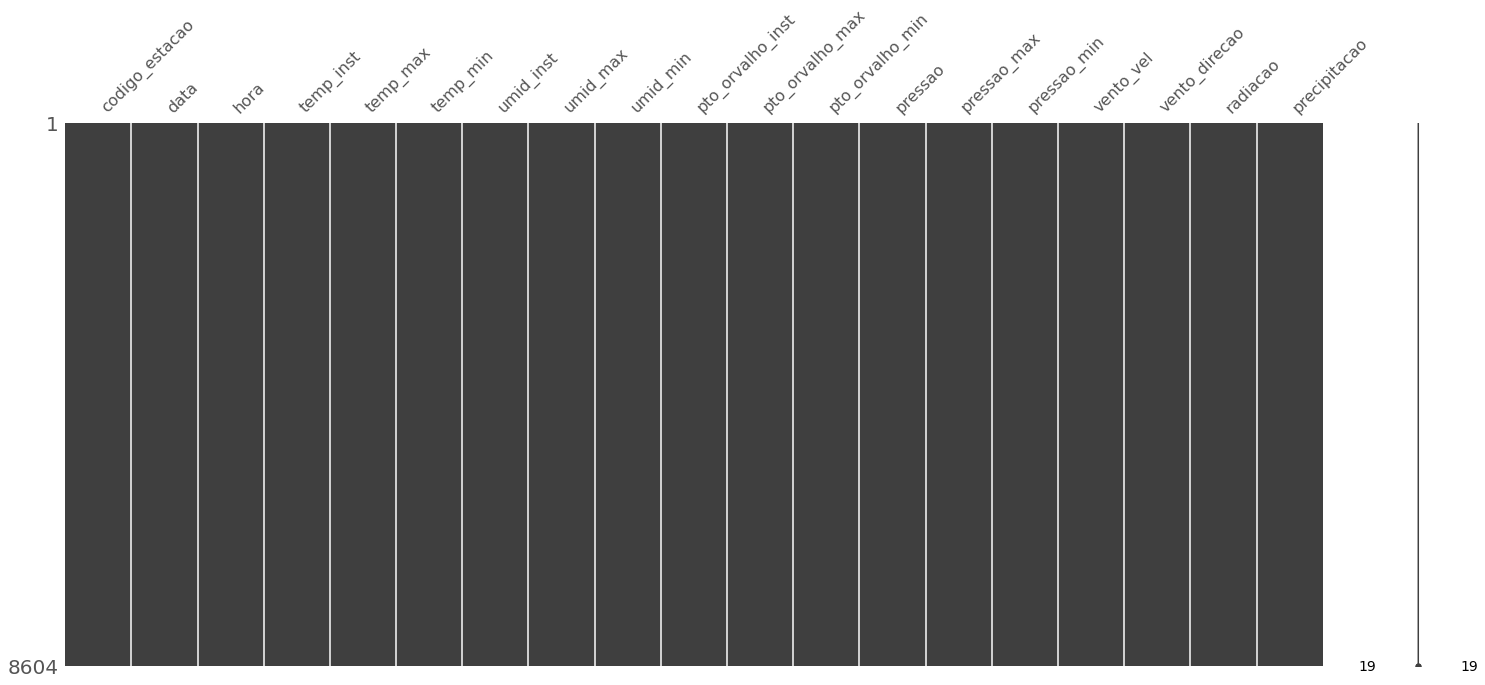

In [49]:
msno.matrix(macapa) # com a matriz de nulidade vemos que os dados estao prontos para o processamento e modelagem

## Seleção de Features 

- Selecionando o nosso X e Y  

In [50]:
macapa.columns

Index(['codigo_estacao', 'data', 'hora', 'temp_inst', 'temp_max', 'temp_min',
       'umid_inst', 'umid_max', 'umid_min', 'pto_orvalho_inst',
       'pto_orvalho_max', 'pto_orvalho_min', 'pressao', 'pressao_max',
       'pressao_min', 'vento_vel', 'vento_direcao', 'radiacao',
       'precipitacao'],
      dtype='object')

In [51]:
y = macapa['temp_inst'] # temperatura no instante
X = macapa.drop(['temp_inst','codigo_estacao','data','hora'], axis=1) # removendo temperatura no instante e algumas features 

- Separando em Treino e Teste

In [52]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=0)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape 

((6022, 15), (2582, 15), (6022,), (2582,))

In [53]:
k_vs_score = []

for k in range(2,17,2): 
    selector = SelectKBest(score_func=f_regression, k=5)

    Xtrain2 = selector.fit_transform(Xtrain, ytrain)
    Xtest2 = selector.transform(Xtest)

    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    mdl.fit(Xtrain2, ytrain)

    p = mdl.predict(Xtest2)

    score = mean_absolute_error(ytest, p)
    print(f'k = {k} - MAE = {score}')

    k_vs_score.append(score)

k = 2 - MAE = 0.187994020559483
k = 4 - MAE = 0.18799402055948297
k = 6 - MAE = 0.18799402055948303
k = 8 - MAE = 0.18799402055948292
k = 10 - MAE = 0.187994020559483
k = 12 - MAE = 0.18799402055948294
k = 14 - MAE = 0.18799402055948292
k = 16 - MAE = 0.18799402055948297


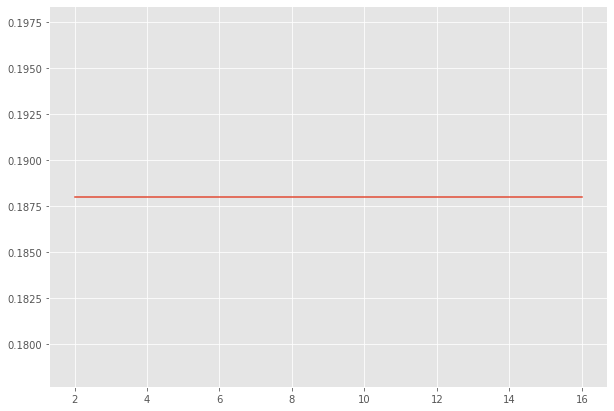

In [54]:
pd.Series(k_vs_score, index=range(2,17,2)).plot(figsize=(10,7)) # vamos printar um grafico de frequencia

In [55]:
selector = SelectKBest(score_func=f_regression, k=8) # selecionamos o intervalo
selector.fit(Xtrain, ytrain)

SelectKBest(k=8, score_func=<function f_regression at 0x7faadcd55170>)

In [56]:
mask = selector.get_support()
Xtest.columns[mask] # vamos ver as features

Index(['temp_max', 'temp_min', 'umid_inst', 'umid_max', 'umid_min',
       'pto_orvalho_min', 'vento_vel', 'radiacao'],
      dtype='object')

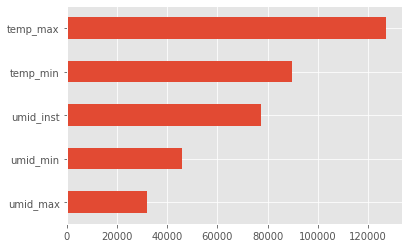

In [57]:
pd.Series(selector.scores_, index=Xtrain.columns).sort_values().tail().plot.barh()

In [58]:
Xtrain.columns

Index(['temp_max', 'temp_min', 'umid_inst', 'umid_max', 'umid_min',
       'pto_orvalho_inst', 'pto_orvalho_max', 'pto_orvalho_min', 'pressao',
       'pressao_max', 'pressao_min', 'vento_vel', 'vento_direcao', 'radiacao',
       'precipitacao'],
      dtype='object')

In [59]:
features = ['temp_max', 'temp_min', 'umid_inst', 'umid_max', 'umid_min'] # selecionando as variveis mais importantes
X_train = Xtrain[features]
X_teste = Xtest[features]
# y_teste = yval[features]

In [60]:
ytest

3420    31.1
4184    28.3
5065    26.8
6133    27.4
3617    30.7
        ... 
8028    25.5
6431    29.5
346     27.2
6871    24.7
1095    25.3
Name: temp_inst, Length: 2582, dtype: float64

### Vamos usar o Random Forest Regressor

In [61]:
regressor = RandomForestRegressor( 
           criterion='mae', 
           max_depth=8,
           max_leaf_nodes=None,
           min_impurity_split=None,
           min_samples_leaf=1,
           min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           n_estimators= 500,
           n_jobs=-1,
           random_state=0,
           verbose=0,
           warm_start=False
)

## Treinando  o modelo

In [62]:
regressor.fit(X_train, ytrain)

RandomForestRegressor(criterion='mae', max_depth=8, n_estimators=500, n_jobs=-1,
                      random_state=0)

## Realizando a predição de "Temperatura no instante" da  base teste

In [63]:
y_pred_test = regressor.predict(X_teste)
y_pred_train = regressor.predict(X_train)

In [64]:
print(f'𝑅² - Coeficiente de determinação: {r2_score(ytrain, y_pred_train).round(8)}') # 𝑅²
print(f'MSE - Erro médio quadrático: {mean_squared_error(ytrain, y_pred_train).round(8)}') # Mean Squared Error
print(f'MAE - Mediana dos erros de predição: {median_absolute_error(ytrain, y_pred_train).round(8)}') # Median Absolute Error

𝑅² - Coeficiente de determinação: 0.9901124
MSE - Erro médio quadrático: 0.07101096
MAE - Mediana dos erros de predição: 0.10565
